In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# === 1) 构造二维高斯“器官/结节”phantom ===
N = 256
FOV = 1.0                               # 物理场景一半边长 mm
xs = np.linspace(-FOV, FOV, N)
ys = np.linspace(-FOV, FOV, N)
X, Y = np.meshgrid(xs, ys)

In [3]:
def gaussian_blob(x0, y0, sigma, amp=1.0):
    return amp * np.exp(-((X-x0)**2 + (Y-y0)**2) / (2*sigma**2))

phantom = (
    gaussian_blob(-0.35, -0.10, 0.10, 0.9) +
    gaussian_blob( 0.25,  0.15, 0.07, 0.7) +
    gaussian_blob( 0.10, -0.30, 0.05, 1.2) +
    0.2 * gaussian_blob( 0.00,  0.00, 0.35, 1.0)
)

phantom = (phantom / phantom.max() * 255).astype(np.uint8)

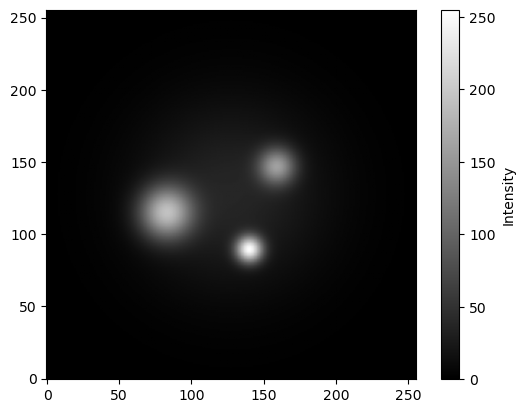

In [4]:
plt.imshow(phantom, cmap="gray", origin="lower")
plt.colorbar(label="Intensity")
plt.show()

In [5]:
angle_ranges = [
    (0.0, 180.0, 0.5), 
]

geo = {
    "geometry": "fan", 
    "detector": "flat",
    "DSO": 600.0, 
    "DSD": 1000.0,
    "n_det": 512, 
    "du": 1.0, "u0": 0.0,
    "img_size": 256, 
    "dx": 2.0, 
    "dy": 2.0,
    "FOV": 100.0, 
    "angle_unit": "deg",
}

In [11]:
# ===========================
# Fan-beam (2D, flat detector) add-ons
# ===========================

# ---------- Angles from two ranges ----------
def angles_from_ranges(angle_ranges, unit: str = "deg") -> np.ndarray:
    parts = []
    for (a, b, s) in angle_ranges:
        if unit == "deg":
            a, b, s = np.deg2rad(a), np.deg2rad(b), np.deg2rad(s)
        arr = np.linspace(a, b, int(round((b - a)/s)) + 1, dtype=np.float32) if s != 0 else np.array([a], dtype=np.float32)
        parts.append(arr)
    thetas = np.unique(np.concatenate(parts))
    thetas.sort()
    return thetas


# --- 工具：与重建窗口（轴对齐矩形）求交，给出参数区间 [t0, t1] ---
def _ray_box_intersection(Sx, Sy, Vx, Vy, x_min, x_max, y_min, y_max):
    t0, t1 = -np.inf, np.inf

    if abs(Vx) < 1e-12:
        if Sx < x_min or Sx > x_max:  # 平行且在盒外
            return None, None
    else:
        tx0 = (x_min - Sx) / Vx
        tx1 = (x_max - Sx) / Vx
        if tx0 > tx1: tx0, tx1 = tx1, tx0
        t0 = max(t0, tx0); t1 = min(t1, tx1)

    if abs(Vy) < 1e-12:
        if Sy < y_min or Sy > y_max:
            return None, None
    else:
        ty0 = (y_min - Sy) / Vy
        ty1 = (y_max - Sy) / Vy
        if ty0 > ty1: ty0, ty1 = ty1, ty0
        t0 = max(t0, ty0); t1 = min(t1, ty1)

    if t1 <= t0:
        return None, None
    return t0, t1

# --- 工具：2D Siddon 线积分（像素为常值 μ_ij，返回 ∑ μ_ij * L_ij） ---
def _siddon_ray_integral_2d(img, dx, dy, Sx, Sy, ux, uy,
                            x_min, x_max, y_min, y_max, t0, t1):
    """
    img: (H,W), 像素中心在 ((k-(W-1)/2)*dx, (l-(H-1)/2)*dy)
    像素边界：
      x_b[m] = x_min + m*dx,  m=0..W
      y_b[n] = y_min + n*dy,  n=0..H
    射线：R(t) = (Sx,Sy) + t*(ux,uy),  t ∈ [t0,t1]
    """
    H, W = img.shape
    # 边界数组
    # 中心坐标定义：x_center(k)= (k-(W-1)/2)*dx
    # 边界：x_min = -(W-1)/2*dx - dx/2, x_max = +(W-1)/2*dx + dx/2
    # 这里调用方已传入一致的 x_min..y_max
    # 起点
    x = Sx + t0 * ux
    y = Sy + t0 * uy
    t  = t0
    eps = 1e-12

    # 把 (x,y) 映射到像素索引
    # 利用边界公式：ix = floor((x - x_min)/dx),  iy = floor((y - y_min)/dy)
    def _idx_x(xv):
        return int(np.floor((xv - x_min) / dx))
    def _idx_y(yv):
        return int(np.floor((yv - y_min) / dy))

    ix = _idx_x(x); iy = _idx_y(y)
    # 边界情况下微小推进
    if ix < 0: ix = 0
    if ix >= W: ix = W - 1
    if iy < 0: iy = 0
    if iy >= H: iy = H - 1

    # 设定步进方向与首次交界时间
    if abs(ux) < eps:
        stepX = 0
        tDeltaX = np.inf
        tMaxX = np.inf
    else:
        if ux > 0:
            stepX = 1
            x_edge_next = x_min + (ix + 1) * dx
        else:
            stepX = -1
            x_edge_next = x_min + ix * dx
        tMaxX   = (x_edge_next - x) / ux + t   # t到下一条x边界
        tDeltaX = dx / abs(ux)                 # 相邻两条x边界的t间隔

    if abs(uy) < eps:
        stepY = 0
        tDeltaY = np.inf
        tMaxY = np.inf
    else:
        if uy > 0:
            stepY = 1
            y_edge_next = y_min + (iy + 1) * dy
        else:
            stepY = -1
            y_edge_next = y_min + iy * dy
        tMaxY   = (y_edge_next - y) / uy + t
        tDeltaY = dy / abs(uy)

    acc = 0.0
    # 主循环：直到穿出盒子
    while t < t1 - eps:
        # 下一事件点（撞到 x 或 y 边界，或区间末端 t1）
        tNext = min(tMaxX, tMaxY, t1)
        seg_len = tNext - t
        if seg_len > 0:
            acc += float(img[iy, ix]) * seg_len

        t = tNext
        if t >= t1 - eps:
            break

        # 更新步进
        hitX = (tMaxX <= tMaxY)
        if hitX and stepX != 0:
            ix += stepX
            tMaxX += tDeltaX
            if ix < 0 or ix >= W:
                break
        if (not hitX) and stepY != 0:
            iy += stepY
            tMaxY += tDeltaY
            if iy < 0 or iy >= H:
                break

    # 注意：此处 acc 的长度单位就是 t 的单位（mm），
    # 因为 R(t)=S+t*u，且 u 为单位方向向量时，t 即为长度。
    # 我们传入的 (ux,uy) 是 cos/sin → 已是单位向量，所以单位自洽。
    return acc

# ---------- s-axis (detector axis, in mm) ----------
def make_s_axis_from_geo(geo: dict) -> np.ndarray:
    n_det = int(geo["n_det"])
    du    = float(geo["du"])
    u0    = float(geo.get("u0", 0.0))
    u     = np.linspace(0, n_det - 1, n_det, dtype=np.float32)
    u_c   = (n_det - 1) * 0.5
    s_mm  = (u - u_c - u0) * du
    return s_mm.astype(np.float32)

# ---------- Geometry sanity checks ----------
def _check_fan_geometry_coverage(geo: dict) -> None:
    DSO = float(geo["DSO"]); DSD = float(geo["DSD"])
    n_det = int(geo["n_det"]); du = float(geo["du"])
    FOV = float(geo.get("FOV", 0.0))
    gamma_max = np.arctan(((n_det - 1) * du) / (2.0 * DSD))
    if FOV > 0 and FOV > DSO * np.sin(gamma_max) + 1e-6:
        raise ValueError(
            f"FOV={FOV:.3f} mm 超出几何可见范围 DSO*sin(gamma_max)={DSO*np.sin(gamma_max):.3f} mm；"
            f"请增大 DSD/n_det/du，或减小 FOV。"
        )

# ---------- Build fan-beam sinogram (ray-driven line integral) ----------
# ---------- Build fan-beam sinogram (ray-driven line integral; grayscale -> μ) ----------
def build_sinogram_fan(
    img: np.ndarray,
    angle_ranges: list[tuple[float, float, float]],
    s_axis_mm: np.ndarray,
    geo: dict,
) -> tuple[np.ndarray, np.ndarray]:
    """
    扇束前向投影（Siddon）：
      - 输入 img 被视为“灰度图”，本函数内部先线性映射为 μ(x,y) [mm^-1] 再做线积分
      - μ 标定：默认把最大灰度映射到 mu_max_mm_inv (默认 0.02 mm^-1，可在 geo 中覆盖)
      - 线积分：pθ(s) = ∑ μ_ij * L_ij(θ,s)
    返回：
      sino: [n_angles, n_det]（线积分，单位≈无量纲）
      thetas: [n_angles]（弧度）
    """
    assert img.ndim == 2
    _check_fan_geometry_coverage(geo)

    # --- angles ---
    unit = geo.get("angle_unit", "deg")
    thetas = angles_from_ranges(angle_ranges, unit=unit)  # radians
    n_angles = len(thetas)

    # --- geometry/grid ---
    H, W = img.shape
    dx = float(geo["dx"]); dy = float(geo.get("dy", dx))
    DSO = float(geo["DSO"]); DSD = float(geo["DSD"])
    n_det = int(geo["n_det"]); assert s_axis_mm.size == n_det

    # 图像窗口的物理边界（与像素中心定义一致）
    x_min = -(W - 1) * 0.5 * dx - 0.5 * dx
    x_max = +(W - 1) * 0.5 * dx + 0.5 * dx
    y_min = -(H - 1) * 0.5 * dy - 0.5 * dy
    y_max = +(H - 1) * 0.5 * dy + 0.5 * dy

    # --- grayscale -> μ(x,y) [mm^-1] ---
    mu_max = float(geo.get("mu_max_mm_inv", 0.02))  # typical soft-tissue order per mm
    img_f = img.astype(np.float32, copy=False)
    vmax = float(img_f.max())
    if vmax <= 0.0 or not np.isfinite(vmax):
        img_mu = np.zeros_like(img_f, dtype=np.float32)
    else:
        # If looks like 8-bit (or just >1.5), normalize accordingly
        if img.dtype == np.uint8 or vmax > 1.5:
            img_mu = (img_f / 255.0) * mu_max
        else:
            img_mu = (img_f / vmax) * mu_max
    # No negative attenuation
    np.maximum(img_mu, 0.0, out=img_mu)

    # --- Siddon line integral ---
    sino = np.zeros((n_angles, n_det), dtype=np.float32)

    for i, th in enumerate(thetas):
        c, s = np.cos(th), np.sin(th)
        Sx, Sy = DSO * c, DSO * s  # source position

        for j in range(n_det):
            s_mm = float(s_axis_mm[j])
            gamma = np.arctan2(s_mm, DSD)
            tp = th + gamma
            ux, uy = np.cos(tp), np.sin(tp)  # unit direction

            # Intersection with reconstruction window
            t0, t1 = _ray_box_intersection(Sx, Sy, ux, uy, x_min, x_max, y_min, y_max)
            if t0 is None:
                continue

            # Siddon accumulate ∑ μ_ij * L_ij
            sino[i, j] = _siddon_ray_integral_2d(
                img_mu, dx, dy, Sx, Sy, ux, uy, x_min, x_max, y_min, y_max, t0, t1
            )

    return sino, thetas





# ---------------------------
# Ram-Lak（沿 s 方向）——与并行版相同思路，但步长是 ds
# ---------------------------
def ramp_filter_s(proj_s: np.ndarray, ds: float, pad: bool = True) -> np.ndarray:
    """
    对每条扇束投影沿探测器方向 s 做 Ram-Lak 滤波。
    proj_s: [n_angles, n_det]
    ds: 探测器物理采样间隔（mm）
    """
    n_angles, n_det = proj_s.shape
    n_pad = int(2 ** np.ceil(np.log2(n_det * 2))) if pad else n_det
    freqs = np.fft.fftfreq(n_pad, d=ds).astype(np.float32)
    ramp  = np.abs(freqs)

    out = np.empty_like(proj_s, dtype=np.float32)
    for i in range(n_angles):
        F  = np.fft.fft(proj_s[i], n=n_pad)
        Ff = F * ramp
        f  = np.fft.ifft(Ff).real[:n_det]
        out[i] = f.astype(np.float32)
    return out


# ---------------------------
# 原生 fan-beam FBP（不做 Parker / 不做 cosine 预加权）
# ---------------------------
def fbp_reconstruct(
    sino_fan: np.ndarray,
    thetas_fan: np.ndarray,
    s_axis_mm: np.ndarray,
    geo: dict,
    img_size: int | None = None,
    pad_filter: bool = True,
) -> np.ndarray:
    """
    原生 fan-beam FBP（flat detector）：
      1) 对投影做 cosine weighting（必需的几何加权）
      2) 沿 s 方向做 Ram-Lak 滤波
      3) 逐角用 Δθ_i 反投影积分
      4) 按总角度 sum(Δθ_i) 做归一化
    说明：
      - 不做 Parker（短扫描补偿）；
      - 几何核仍使用 DSO / (DSO - x cosθ - y sinθ)^2（雅可比），不属于“补偿权重”。
    """
    _check_fan_geometry_coverage(geo)

    n_angles, n_det = sino_fan.shape
    assert thetas_fan.shape[0] == n_angles
    assert s_axis_mm.shape[0] == n_det

    DSO = float(geo["DSO"]); DSD = float(geo["DSD"])
    du  = float(geo["du"])
    dx  = float(geo["dx"]);  dy  = float(geo.get("dy", dx))

    if img_size is None:
        img_size = int(geo.get("img_size", 256))

    # 图像网格（mm）
    H = W = img_size
    xs = (np.arange(W, dtype=np.float32) - (W - 1) * 0.5) * dx
    ys = (np.arange(H, dtype=np.float32) - (H - 1) * 0.5) * dy
    XX, YY = np.meshgrid(xs, ys)

    # --- (1) cosine weighting（flat detector 必需，否则会强度畸变） ---
    # gamma: 每个通道的扇角；权重 = cos(gamma)
    gamma = np.arctan2(s_axis_mm.astype(np.float32), np.float32(DSD))  # [n_det]
    sino_w = sino_fan * np.cos(gamma, dtype=np.float32)[None, :]

    # --- (2) 滤波（沿 s；ds = du） ---
    ds = du
    sino_f = ramp_filter_s(sino_w, ds=ds, pad=pad_filter)  # [n_angles, n_det]

    # --- (3) 逐角权重 Δθ_i（支持不等间隔角度与分段） ---
    if n_angles == 0:
        return np.zeros((H, W), dtype=np.float32)
    dtheta = np.empty(n_angles, dtype=np.float32)
    if n_angles == 1:
        dtheta[0] = np.pi  # 退化情形，给个合理面积
    else:
        dtheta[0]    = thetas_fan[1] - thetas_fan[0]
        dtheta[-1]   = thetas_fan[-1] - thetas_fan[-2]
        dtheta[1:-1] = 0.5 * (thetas_fan[2:] - thetas_fan[:-2])
    # 防止极端小/负数造成数值问题
    dtheta = np.clip(dtheta, 1e-8, None)
    total_angle = float(np.sum(dtheta))

    # --- (4) 反投影 ---
    rec = np.zeros((H, W), dtype=np.float32)

    # 预备插值常量
    s0 = s_axis_mm[0]; s1 = s_axis_mm[-1]
    scale = (n_det - 1) / (s1 - s0)  # s_mm -> 索引

    for i, th in enumerate(thetas_fan):
        c, s = np.cos(th), np.sin(th)

        denom = (DSO - (XX * c + YY * s))                     # 距源轴向距离
        s_mm  = DSD * (-(XX) * s + (YY) * c) / denom          # 像素对应探测器坐标（mm）

        # 线性插值采样投影
        u  = (s_mm - s0) * scale
        u0 = np.floor(u).astype(np.int64)
        w  = (u - u0).astype(np.float32)

        valid0 = (u0 >= 0) & (u0 < n_det)
        valid1 = (u0 + 1 >= 0) & (u0 + 1 < n_det)

        proj_i = np.zeros_like(XX, dtype=np.float32)
        p = sino_f[i]

        proj_i[valid0] += p[u0[valid0]] * (1.0 - w[valid0])
        proj_i[valid1] += p[(u0 + 1)[valid1]] *        w[valid1]

        # 扇束几何核（雅可比）
        kernel = (DSO / (denom ** 2)).astype(np.float32)

        rec += (proj_i * kernel) * dtheta[i]

    # --- (5) 按总角度归一化；再可选单位化到 [0,1] ---
    if total_angle > 0:
        rec *= (1.0 / total_angle)

    m = float(rec.max())
    if m > 0:
        rec /= m
    return rec


In [7]:
# s-axis in mm
s_axis = make_s_axis_from_geo(geo)

# Build fan-beam sinogram from your phantom/image:
sino_fan, thetas_fan = build_sinogram_fan(phantom, angle_ranges, s_axis, geo)


In [12]:
rec = fbp_reconstruct(
    sino_fan=sino_fan,
    thetas_fan=thetas_fan,
    s_axis_mm=s_axis,
    geo=geo,
    img_size=geo["img_size"],
    pad_filter=True
)

In [13]:
def visualize(
    phantom: np.ndarray,
    sino: np.ndarray,
    rec: np.ndarray,
    thetas: np.ndarray,                 # 你生成的角度序列
    s_axis: np.ndarray | None = None,   # 探测器坐标（mm）；不给则用通道索引
    angle_unit: str = "rad",            # {"rad","deg"} 与 thetas 一致
    save_path: str | None = None,
    cmap_phantom: str = "gray",
    cmap_sino: str = "gray",
    cmap_rec: str = "gray",
):
    """
    [phantom] (H,W), [sino] (n_angles, n_det), [rec] (H,W)
    thetas: 你的角度序列（与 sino 的第0维一一对应）
    s_axis: 探测器坐标（mm），长度 = n_det；若为 None，则显示通道索引
    """
    n_angles, n_det = sino.shape
    assert thetas.shape[0] == n_angles, "thetas 与 sino 角度维不一致"

    # 角度转可读标签
    if angle_unit == "rad":
        thetas_disp = np.rad2deg(thetas)
        y_label = "Angle (deg)"
    else:
        thetas_disp = thetas
        y_label = "Angle (deg)" if angle_unit.lower().startswith("deg") else "Angle"

    # 选择若干刻度，防止过密
    k = min(6, n_angles)
    y_idx = np.linspace(0, n_angles - 1, k).astype(int)
    y_labs = [f"{thetas_disp[i]:.1f}°" for i in y_idx]

    # x 轴（探测器）刻度
    if s_axis is not None and len(s_axis) == n_det:
        x_label = "detector range(mm)"
        kx = min(6, n_det)
        x_idx = np.linspace(0, n_det - 1, kx).astype(int)
        x_labs = [f"{s_axis[j]:.1f}" for j in x_idx]
    else:
        x_label = "Detector channel"
        kx = min(6, n_det)
        x_idx = np.linspace(0, n_det - 1, kx).astype(int)
        x_labs = [str(j) for j in x_idx]

    fig, axes = plt.subplots(1, 3, figsize=(12, 3.6))

    # Phantom
    axes[0].imshow(phantom, origin="lower", cmap=cmap_phantom)
    axes[0].set_title("Phantom")
    axes[0].set_xlabel("x (mm)")
    axes[0].set_ylabel("y (mm)")

    # Sinogram（按照角度刻度）
    im1 = axes[1].imshow(sino, aspect="auto", origin="lower", cmap=cmap_sino)
    axes[1].set_title("Fan-beam Sinogram")
    axes[1].set_xlabel(x_label)
    axes[1].set_ylabel(y_label)
    axes[1].set_yticks(y_idx)
    axes[1].set_yticklabels(y_labs)
    axes[1].set_xticks(x_idx)
    axes[1].set_xticklabels(x_labs, rotation=0)
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    # Reconstruction
    axes[2].imshow(rec, origin="lower", cmap=cmap_rec)
    angle_min = np.min(thetas_disp)
    angle_max = np.max(thetas_disp)
    axes[2].set_title(f"Reconstruction (Fan-FBP)\nAngles: {angle_min:.1f}°–{angle_max:.1f}°")
    axes[2].set_xlabel("x (mm)")
    axes[2].set_ylabel("y (mm)")


    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

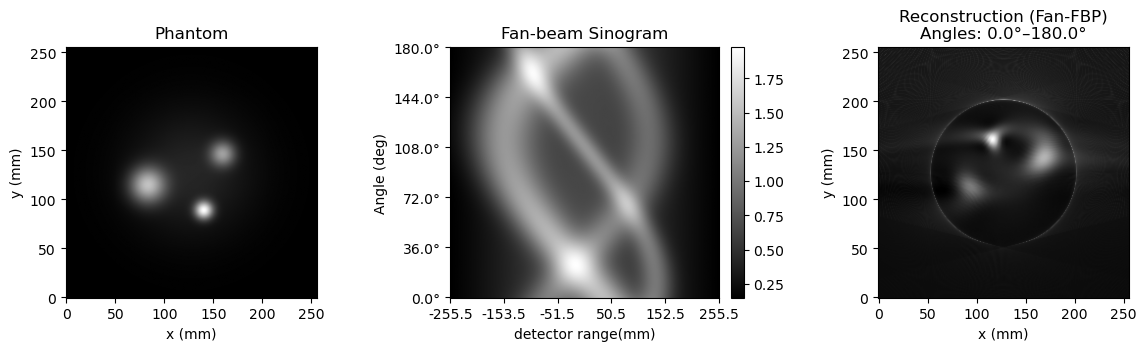

In [14]:
visualize(
        phantom=phantom,
        sino=sino_fan,
        rec=rec,
        thetas=thetas_fan,      # 用你生成的角度
        s_axis=s_axis,          # 若不传则横轴用通道索引
        angle_unit="rad",
        save_path= None,  # 或者 None 不保存
    )